# Ideal Parameter Analysis ($\delta=2.25$, $\tau=0.5$, $\alpha=2$) ($\tau$ very low)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau=0.5
expected_alpha=2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

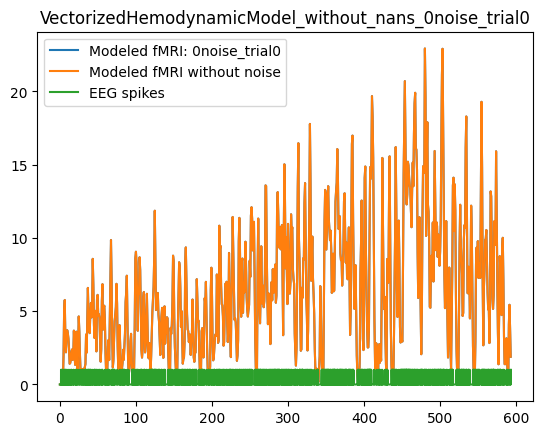

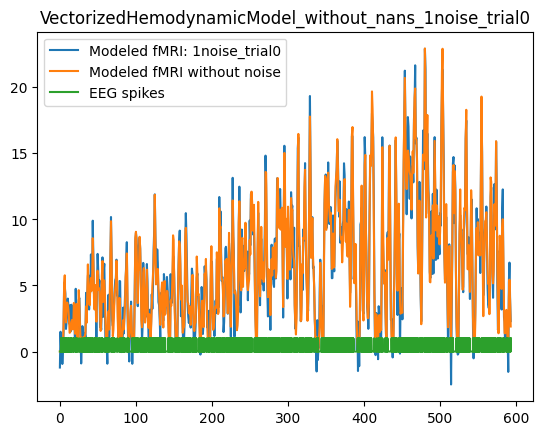

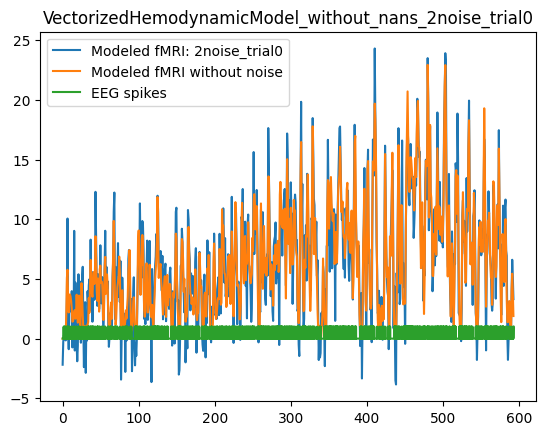

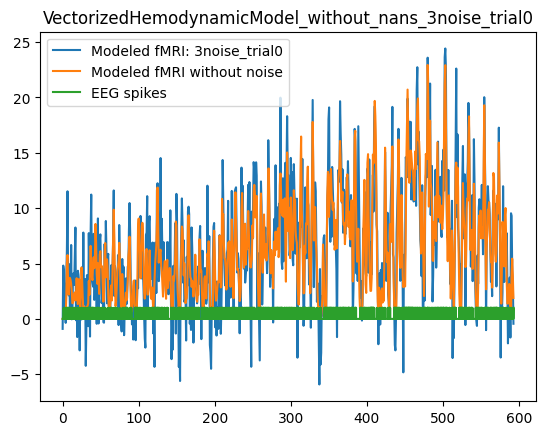

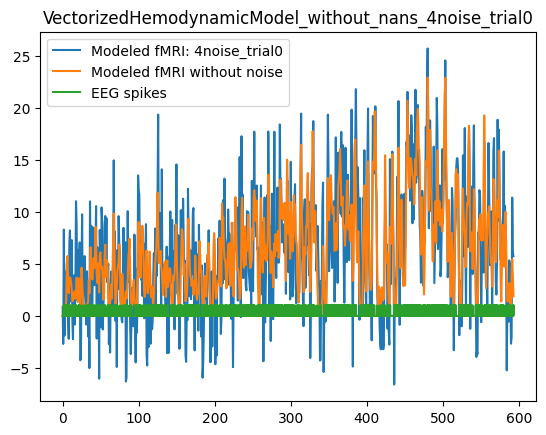

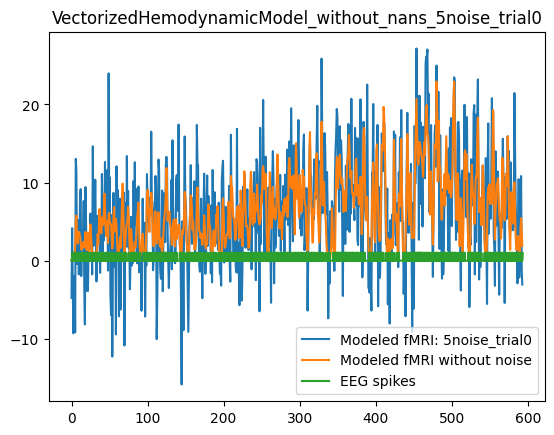

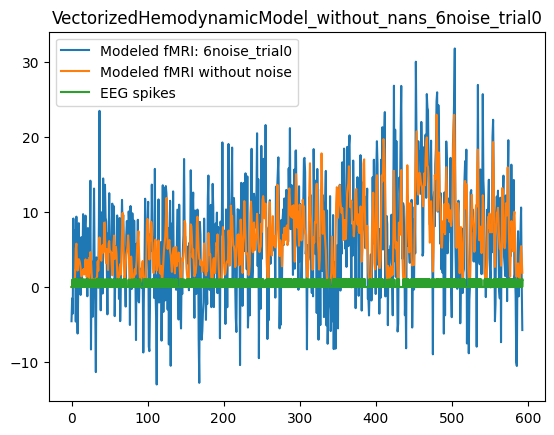

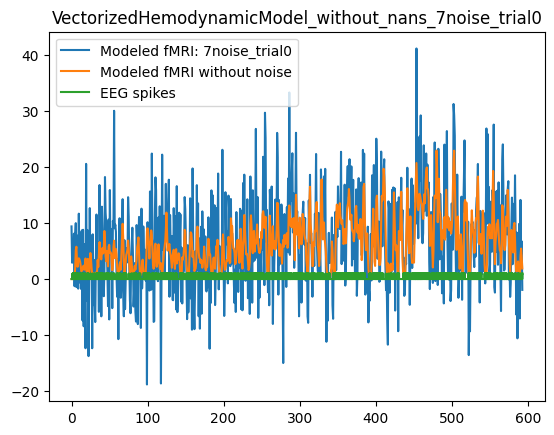

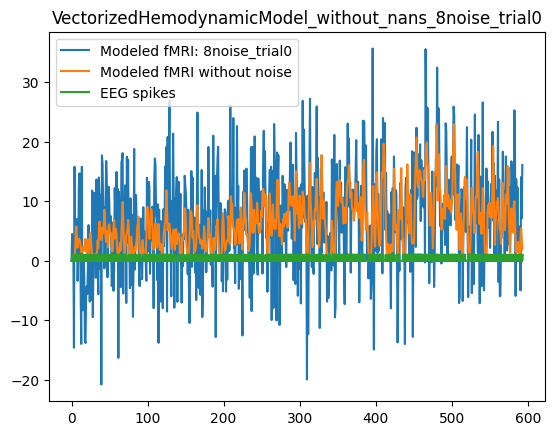

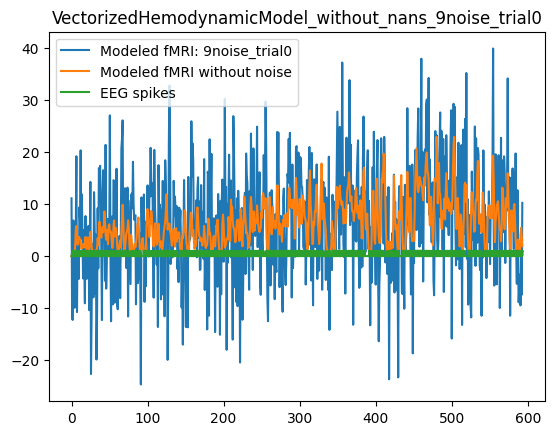

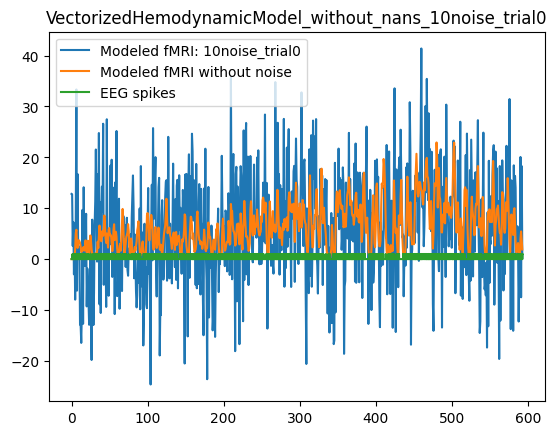

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 0.5, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.25, tau=0.5, alpha=2


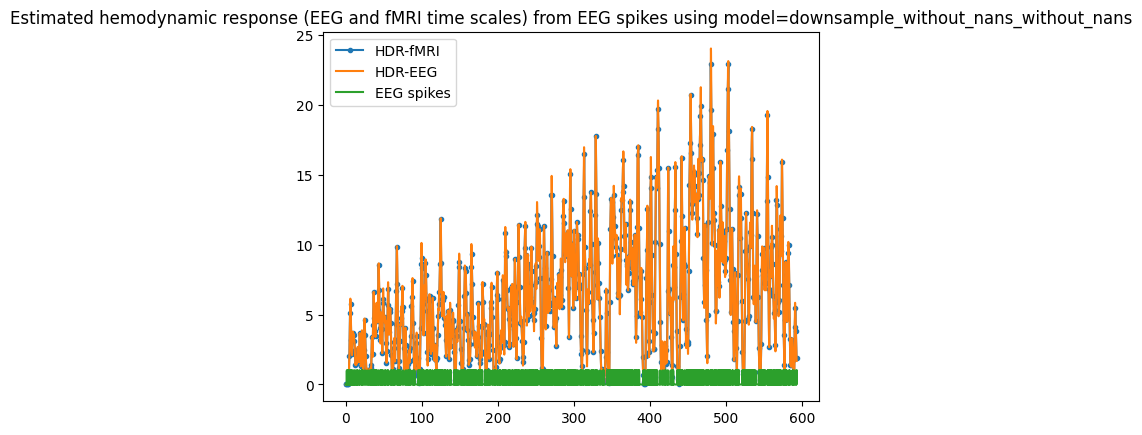

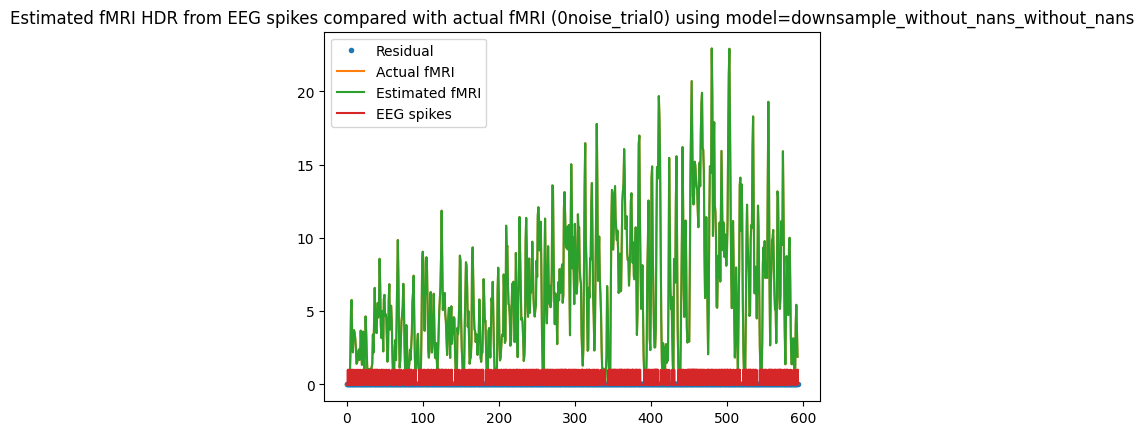

Residual Variance is 0.000000


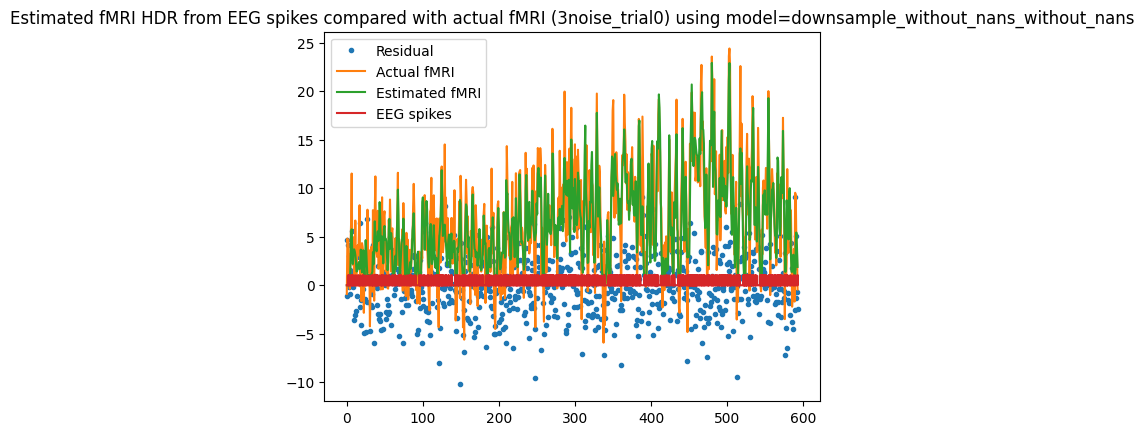

Residual Variance is 9.007328


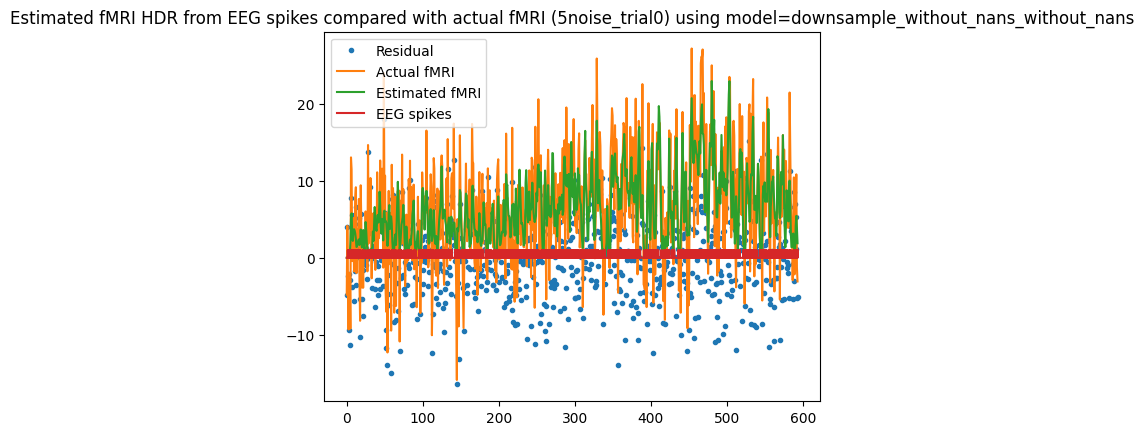

Residual Variance is 27.161460


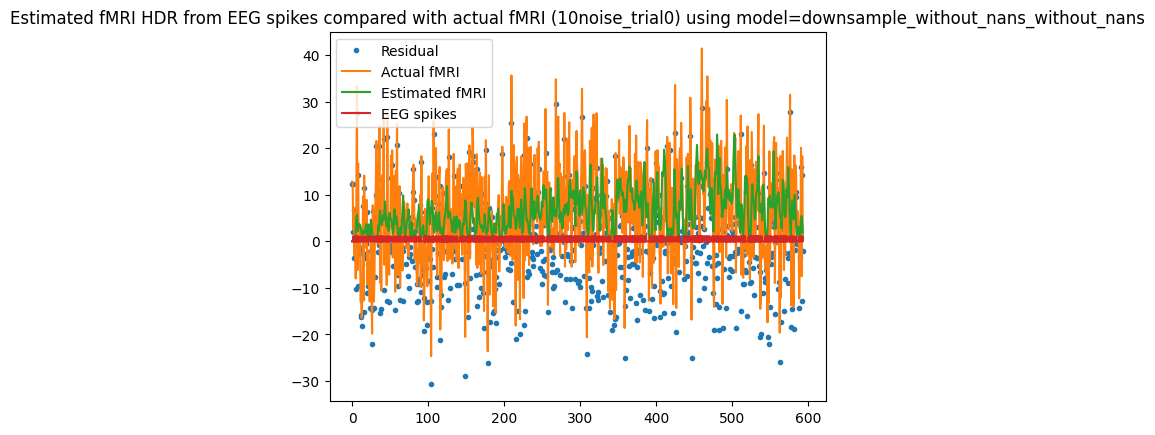

Residual Variance is 101.467395


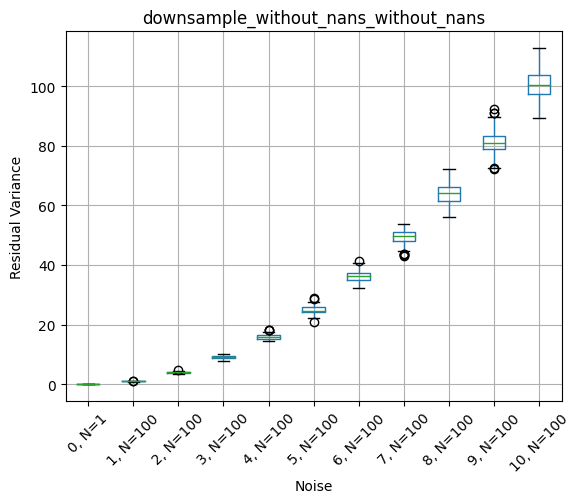

Scoring downsample_without_nans_with_nans delta=2.25, tau=0.5, alpha=2


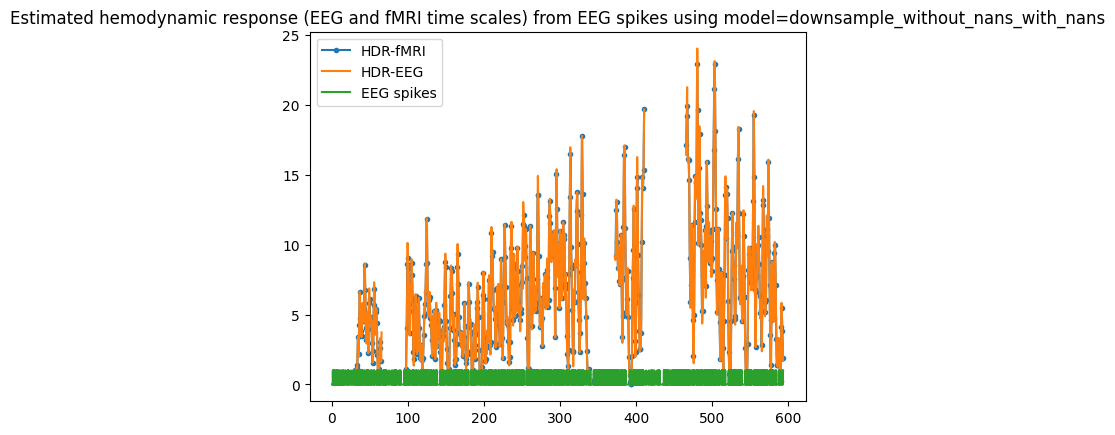

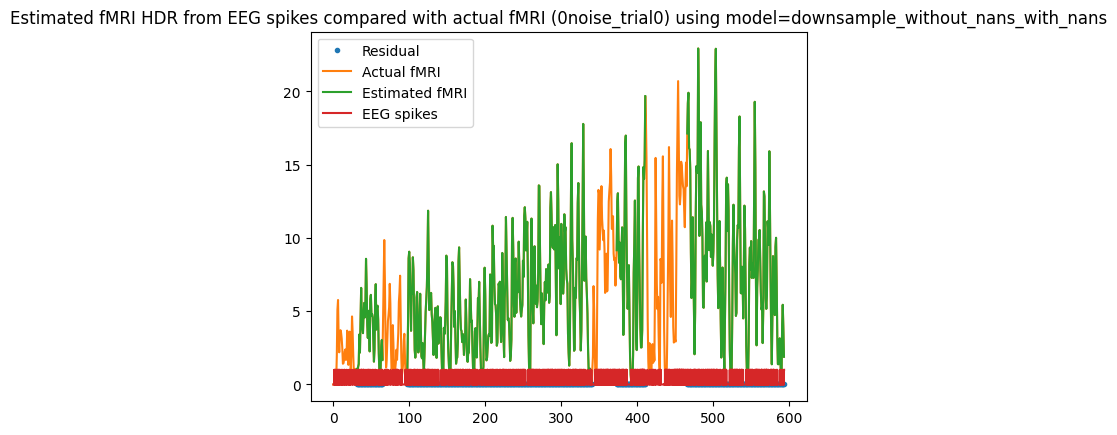

Residual Variance is 0.000000


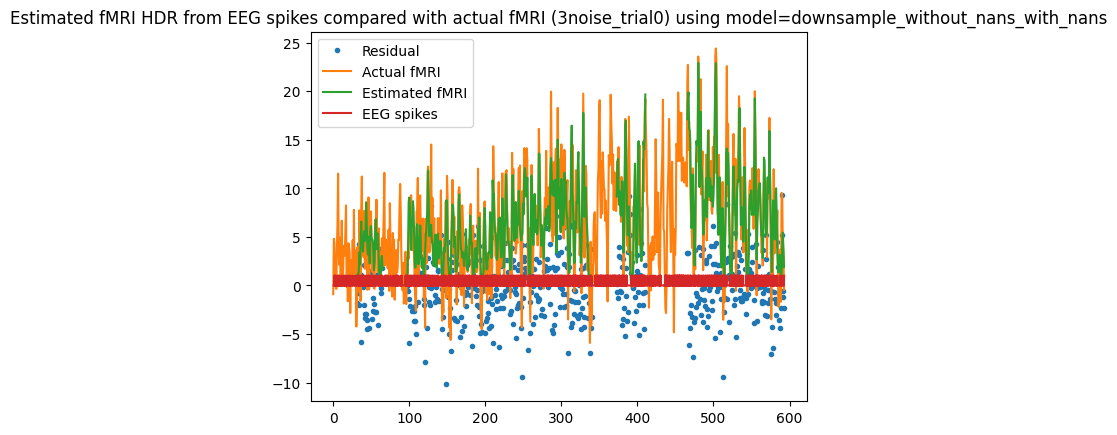

Residual Variance is 9.537756


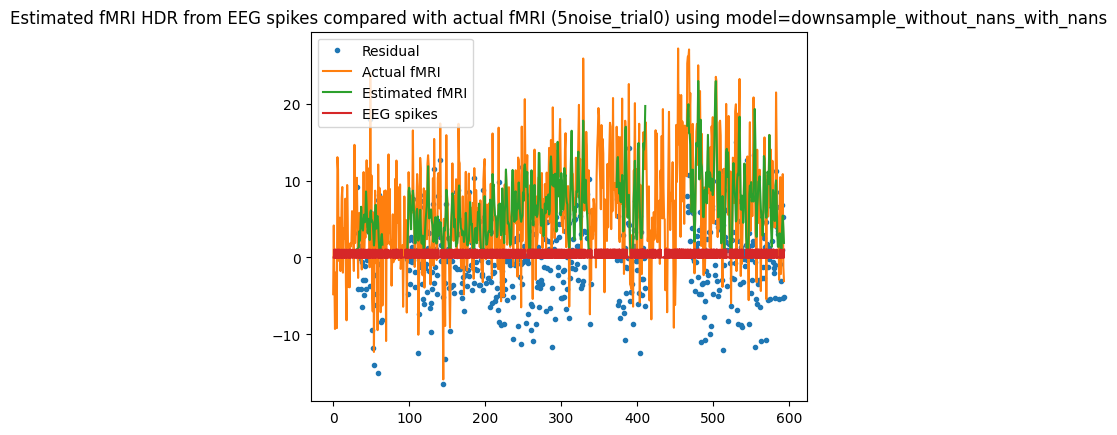

Residual Variance is 28.058151


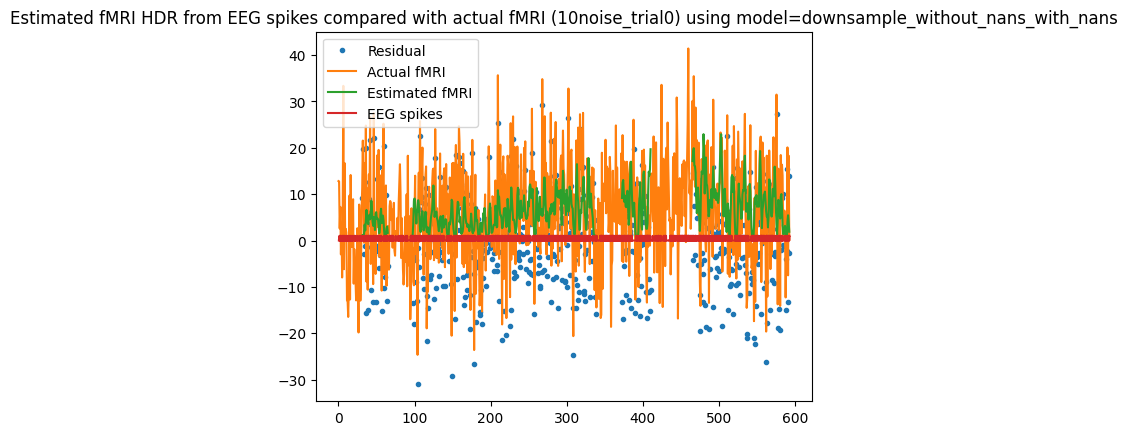

Residual Variance is 103.860058


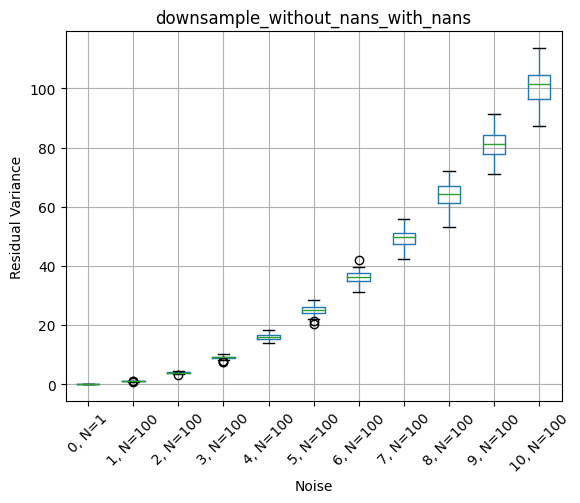

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans   6.243223547586097   
1         downsample_without_nans_with_nans   6.490150800695823   
2      downsample_without_nans_without_nans    5.93582502682098   
3         downsample_without_nans_with_nans   6.180741023378952   
4      downsample_without_nans_without_nans   5.637049949991456   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans  14.688481552648776   
18938  downsample_without_nans_without_nans   15.20329919733544   
18939     downsample_without_nans_with_nans  14.762292098600708   
18940  downsample_without_nans_without_nans  15.290299222643034   
18941     downsample_without_nans_with_nans  14.830756130071865   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0       7.144358715478168  11.117494244240985  14.914982768988837   
1       7.308063801220163  11.181411011791502  15.885390157574589   
2       6.840484790570824  10.791448193955727  14.618724133575531   
3       7.002826151865732  10.850414786657385  15.571200473921358   
4       6.545610764446481  10.472787875592175   14.33113199534067   
...                   ...                 ...                 ...   
18937  15.890389819313013  18.812036948995413  24.235843105987286   
18938   16.41883869781063  19.571101022101512  24.148568169759173   
18939  15.964329230350828  18.899824437079964  24.314738390790207   
18940  16.504400232331722  19.665636143855657   24.23582924529359   
18941  16.033021062835225  18.981540077689893   24.38809467704568   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0      21.070657477508252  33.966459496422914  ...   6.740150696032114   
1      21.537917620716666   35.42234122074996  ...   6.872941763306175   
2       20.78418845146777  33.658223367250635  ...   6.441552060840223   
3       21.24584841997404   35.10200404244307  ...    6.57488524837126   
4      20.506848091404223    33.3574649083784  ...  6.1522272988422655   
...                   ...                 ...  ...                 ...   
18937  28.766697445373573  41.741613846127215  ...   15.57136307145868   
18938  29.573174112635144   42.18118078388324  ...     16.108465042093   
18939  28.820233803814762   41.81555893588262  ...   15.63944416277171   
18940     29.636608171769    42.2663841601765  ...  16.191877734963327   
18941   28.86892382276358   41.88436177598969  ...  15.702457338576522   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0       10.05286228588648  14.623403017063563   22.91578923955265   
1      10.240748012215688  15.096978954927632   21.97423546358152   
2       9.757043509924205  14.335201138561837  22.591132721950345   
3       9.941619025609949   14.80109149298888   21.67223679814739   
4       9.469407921941105  14.054647338669843  22.274361845480442   
...                   ...                 ...                 ...   
18937  18.359454517783377  22.651570296215162   29.64542003077926   
18938   18.71060496982082   22.47992991410408   30.98822596907754   
18939  18.425938296576387   22.72353348973354  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 0.6968850867719861; at
      delta   tau  alpha
8778   1.95  0.75   1.75


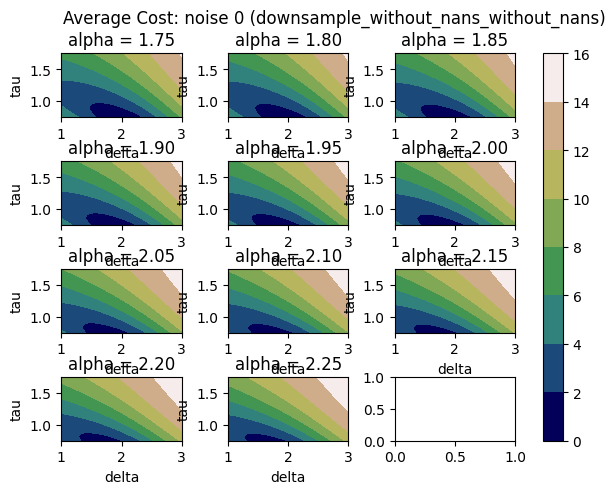

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                               6.243224             
2                                               5.935825             
4                                               5.637050             
6                                               5.347491             
8                                               5.067708             
...                                                  ...             
18932                                          14.906846             
18934                                          15.011877             
18936                                          15.110591             
18938                                          15.203299             
18940                                          15.290299             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 0.5, Alpha target: 2


delta   tau  alpha
0   1.95  0.75   1.75

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 0.5, Alpha target: 2


noise iteration      cost  delta   tau  alpha
0      0         0  0.696885   1.95  0.75   1.75

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         1.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration      cost  delta   tau  alpha
0      0         0  0.696885   1.95  0.75   1.75

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration      cost  delta   tau  alpha
0      0         0  0.696885   1.95  0.75   1.75

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 0.7107496712690986; at
      delta   tau  alpha
9241    2.0  0.75   1.75


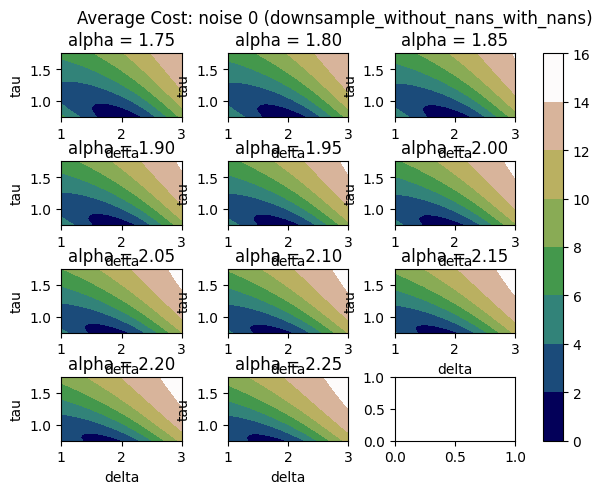

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                               6.490151          
3                                               6.180741          
5                                               5.879109          
7                                               5.585904          
9                                               5.301748          
...                                                  ...          
18933                                          14.523547          
18935                                          14.609010          
18937                                          14.688482          
18939                                          14.762292          
18941                                          14.830756          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 0.5, Alpha target: 2


delta   tau  alpha
0    2.0  0.75   1.75

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 0.5, Alpha target: 2


noise iteration     cost  delta   tau  alpha
0      0         0  0.71075    2.0  0.75   1.75

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         1.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration     cost  delta   tau  alpha
0      0         0  0.71075    2.0  0.75   1.75

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration     cost  delta   tau  alpha
0      0         0  0.71075    2.0  0.75   1.75

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 1.6999205612194948; at
      delta   tau  alpha
8778   1.95  0.75   1.75


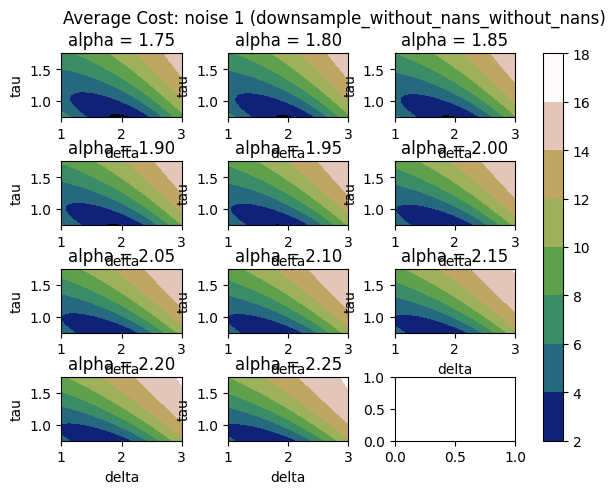

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 4.666122328709465; at
      delta   tau  alpha
8778   1.95  0.75   1.75


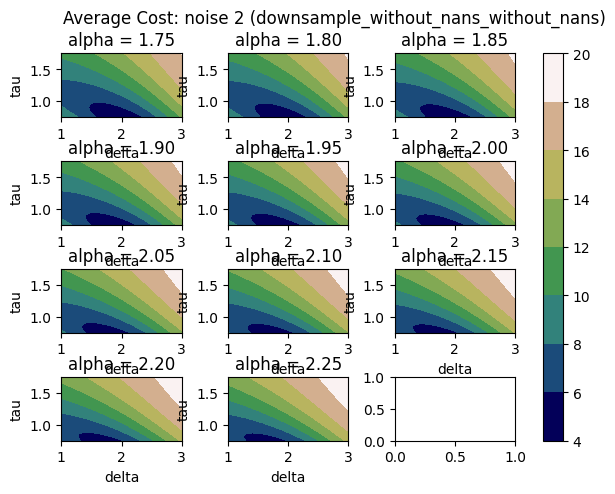

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 9.691275167150522; at
      delta   tau  alpha
8778   1.95  0.75   1.75


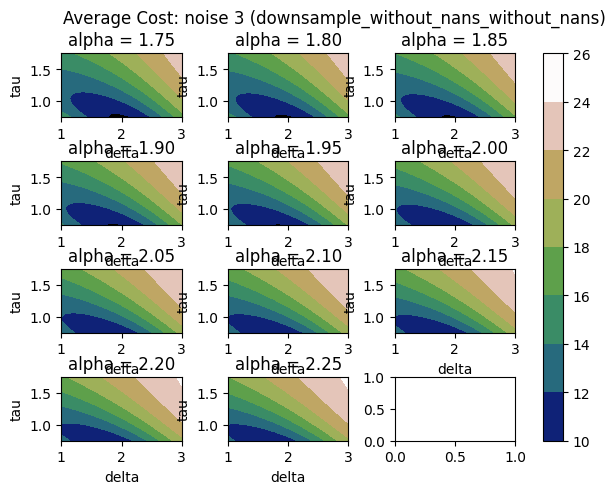

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 16.649661781041633; at
      delta   tau  alpha
9240    2.0  0.75   1.75


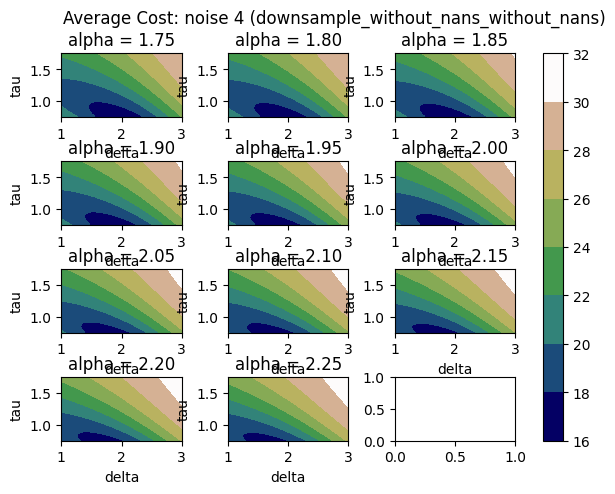

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 25.586656250531863; at
      delta   tau  alpha
8778   1.95  0.75   1.75


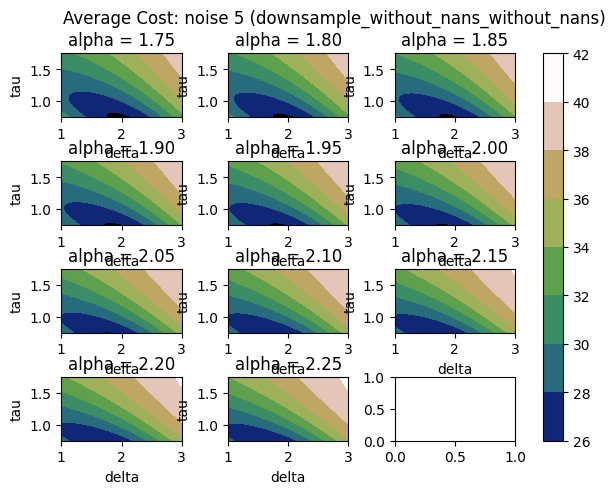

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.98746119934295; at
      delta   tau  alpha
8778   1.95  0.75   1.75


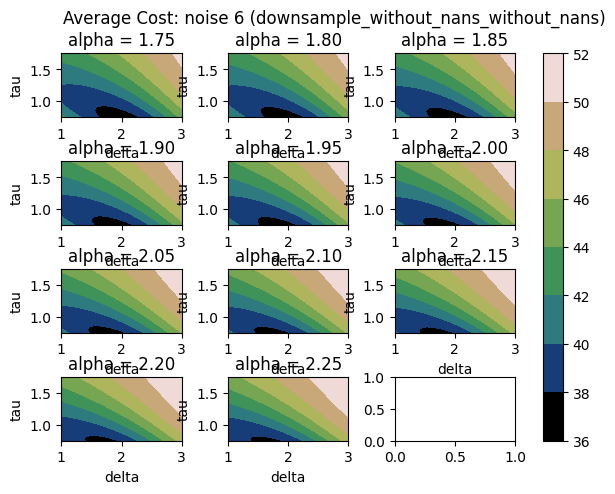

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 50.01484584094581; at
      delta   tau  alpha
8778   1.95  0.75   1.75


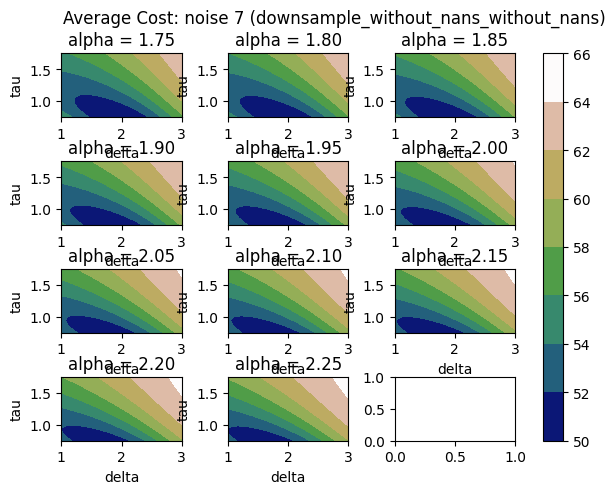

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 64.64394139648563; at
      delta   tau  alpha
8778   1.95  0.75   1.75


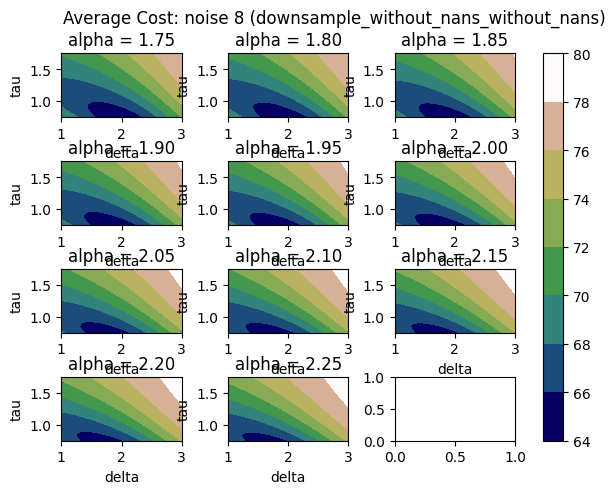

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 81.79220497932994; at
      delta   tau  alpha
9240    2.0  0.75   1.75


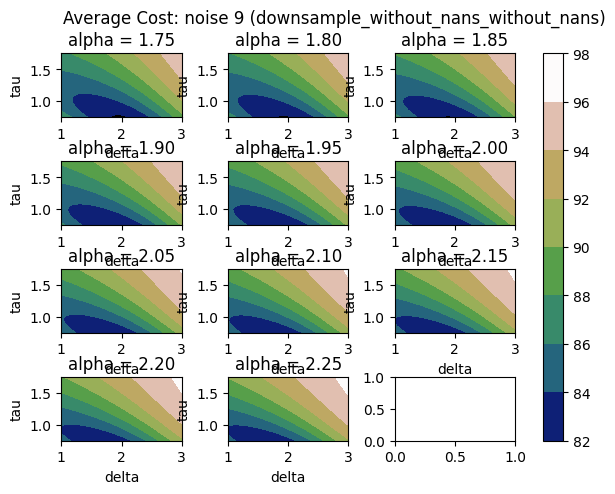

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 101.39151243803474; at
      delta   tau  alpha
8778   1.95  0.75   1.75


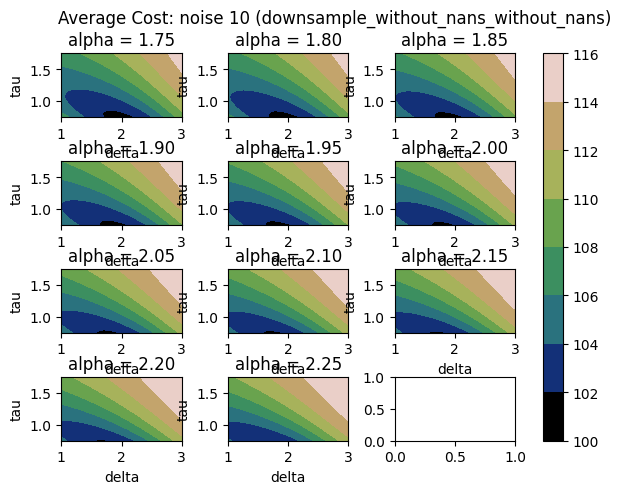

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

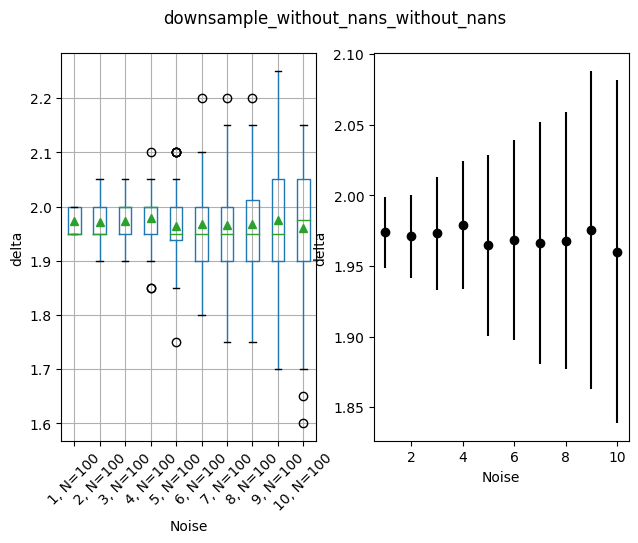

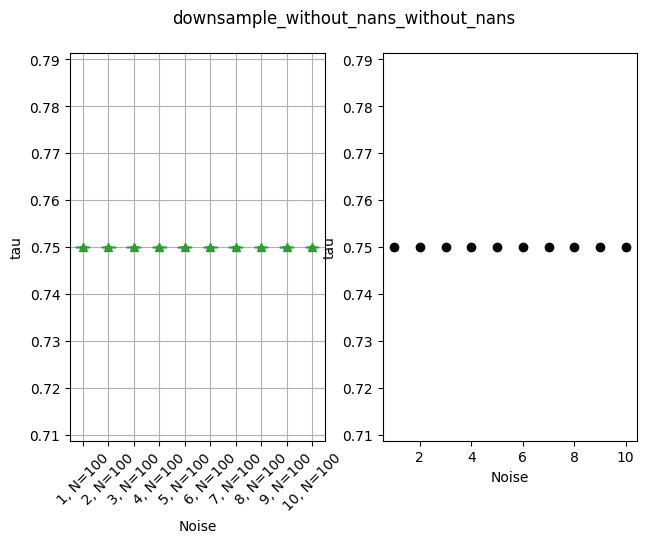

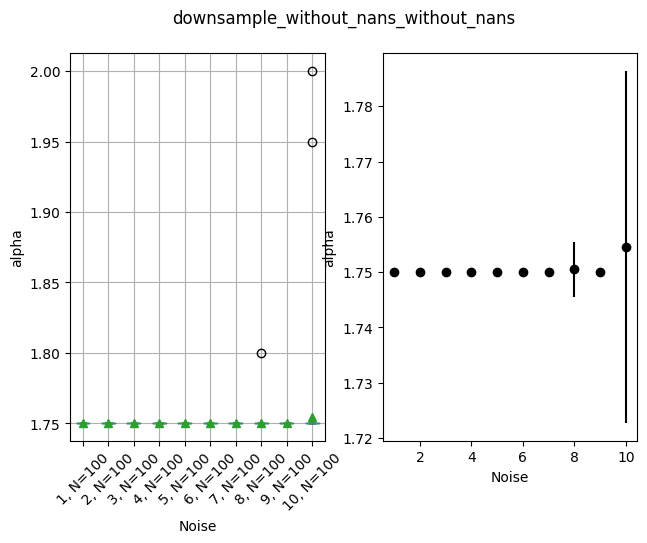

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 1.7037318147228815; at
      delta   tau  alpha
9241    2.0  0.75   1.75


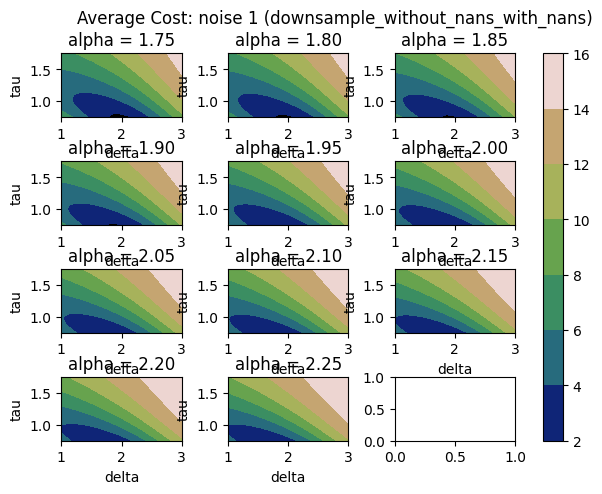

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.665741639359565; at
      delta   tau  alpha
9241    2.0  0.75   1.75


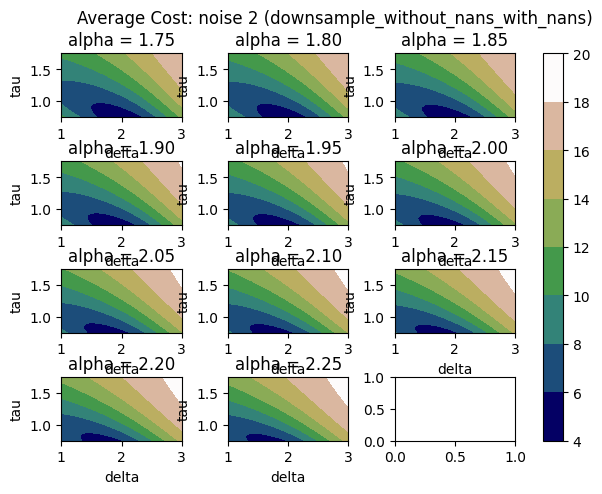

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 9.733814085162884; at
      delta   tau  alpha
9241    2.0  0.75   1.75


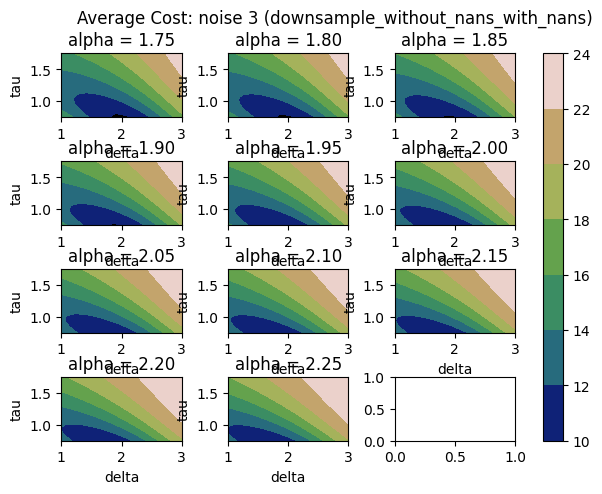

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 16.689619077593697; at
      delta   tau  alpha
9241    2.0  0.75   1.75


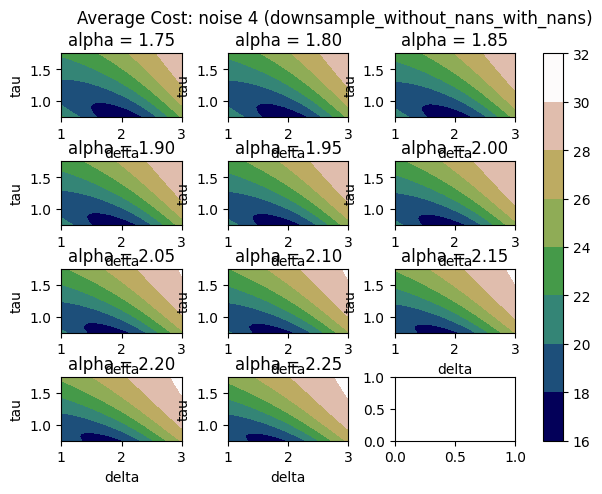

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 25.697122038821508; at
      delta   tau  alpha
9241    2.0  0.75   1.75


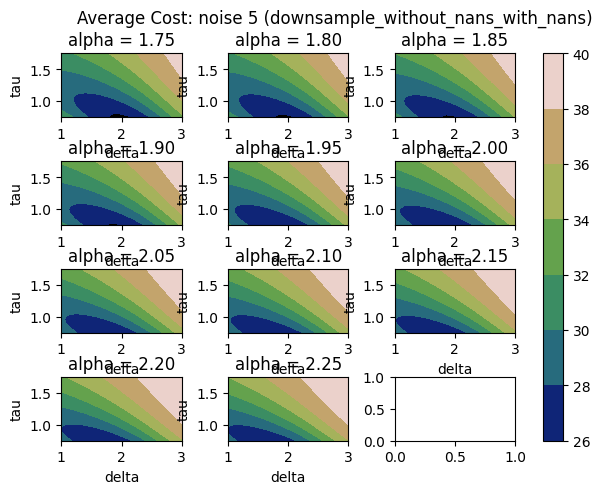

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 37.00777924789251; at
      delta   tau  alpha
9241    2.0  0.75   1.75


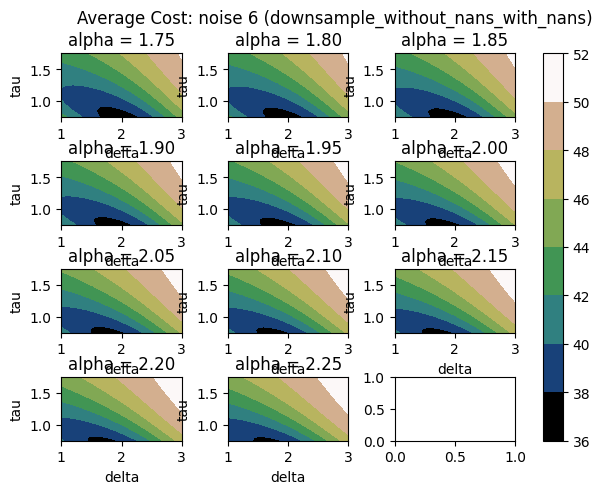

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 49.97558736583509; at
      delta   tau  alpha
9241    2.0  0.75   1.75


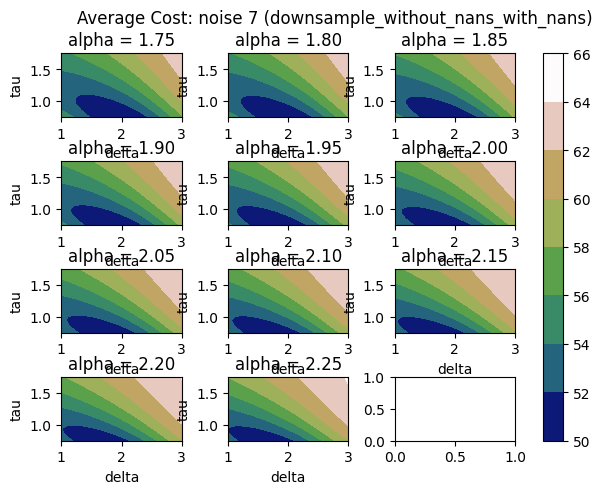

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 64.71102761411093; at
      delta   tau  alpha
9241    2.0  0.75   1.75


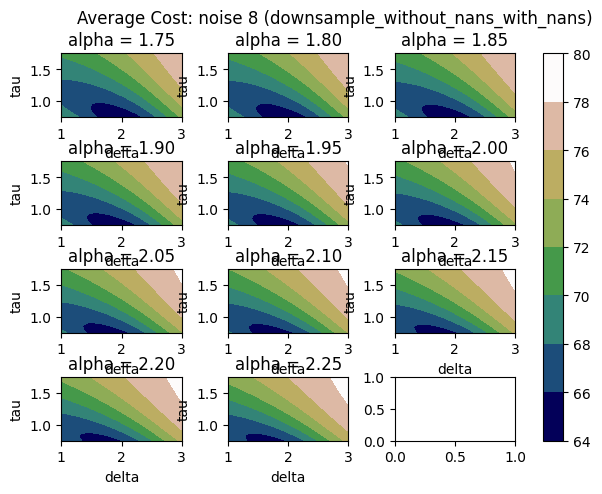

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 81.79154919069953; at
      delta   tau  alpha
9241    2.0  0.75   1.75


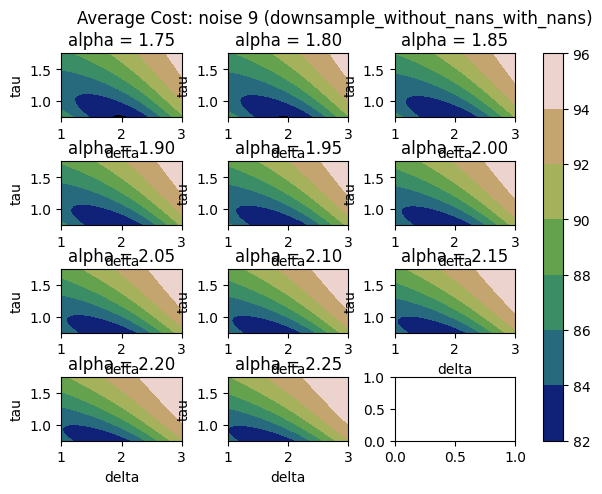

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 101.60679595106781; at
      delta   tau  alpha
8779   1.95  0.75   1.75


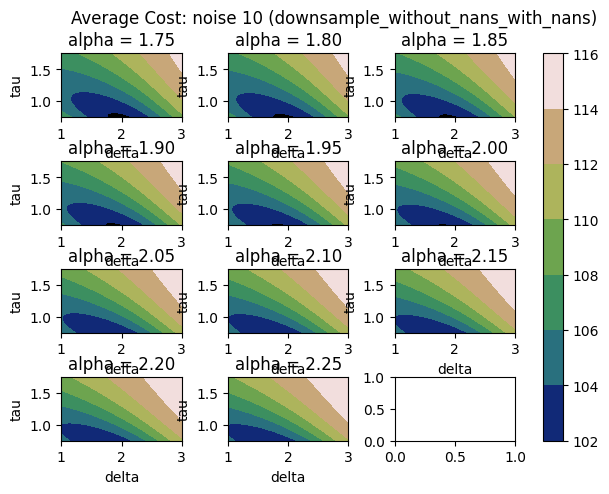

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


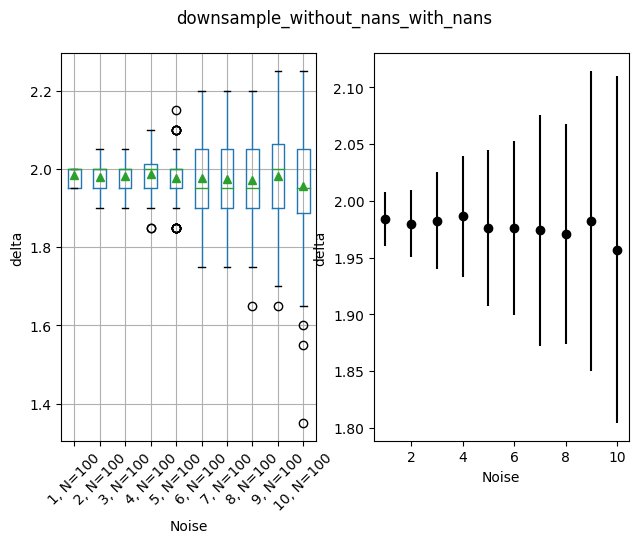

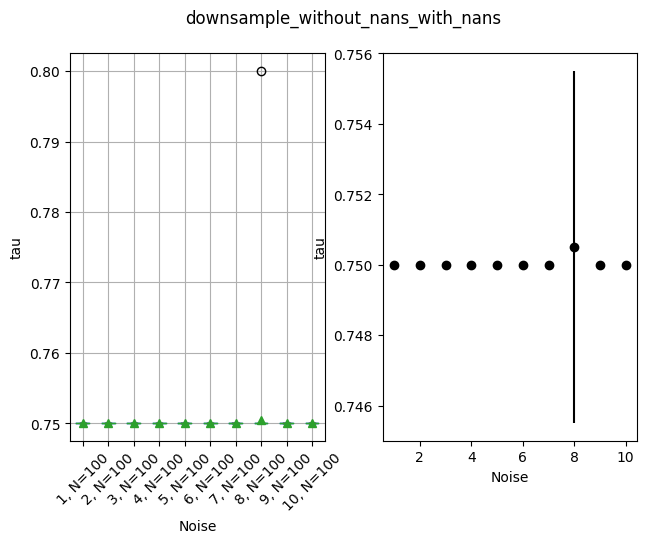

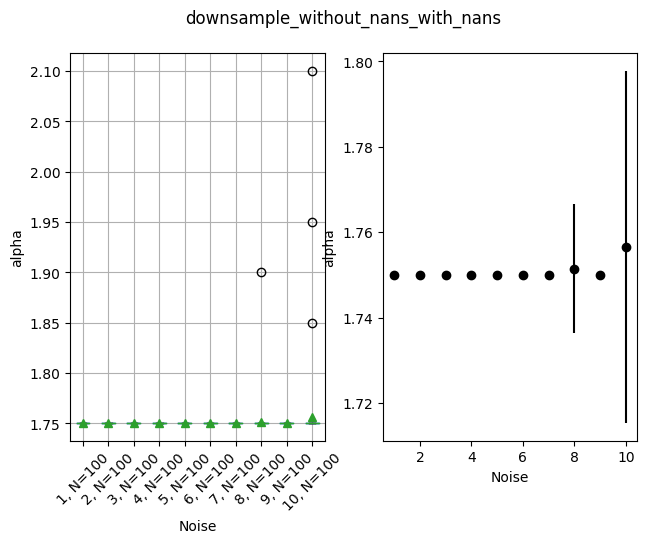

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta   tau alpha
0         1         0    1.771206  1.9500000000000008  0.75  1.75
1         1         1    1.683481  1.9500000000000008  0.75  1.75
2         1         3    1.738849  1.9500000000000008  0.75  1.75
3         1         5    1.699584  1.9500000000000008  0.75  1.75
4         1         6    1.662434  1.9500000000000008  0.75  1.75
...     ...       ...         ...                 ...   ...   ...
996      10        12  104.953818  2.1500000000000012  0.75  1.75
997      10        20  105.750464  2.1500000000000012  0.75  1.75
998      10        35  103.385311  2.1500000000000012  0.75  1.75
999      10        49   91.316097  2.1500000000000012  0.75  1.75
1000     10        70  105.475007  2.1500000000000012  0.75  1.75

[1001 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                    
                       count  mean  std  min  25%  50%  75%  max
noise                                                           
1                      100.0  1.00  0.0  1.0  1.0  1.0  1.0  1.0
2                      100.0  1.00  0.0  1.0  1.0  1.0  1.0  1.0
3                      100.0  1.00  0.0  1.0  1.0  1.0  1.0  1.0
4                      100.0  1.00  0.0  1.0  1.0  1.0  1.0  1.0
5                      100.0  1.00  0.0  1.0  1.0  1.0  1.0  1.0
6                      100.0  1.00  0.0  1.0  1.0  1.0  1.0  1.0
7                      100.0  1.00  0.0  1.0  1.0  1.0  1.0  1.0
8                      100.0  1.00  0.0  1.0  1.0  1.0  1.0  1.0
9                      100.0  1.00  0.0  1.0  1.0  1.0  1.0  1.0
10                     100.0  1.01  0.1  1.0  1.0  1.0  1.0  2.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration        cost               delta   tau alpha
0         1         0    1.771206  1.9500000000000008  0.75  1.75
1         1         1    1.683481  1.9500000000000008  0.75  1.75
2         1         3    1.738849  1.9500000000000008  0.75  1.75
3         1         5    1.699584  1.9500000000000008  0.75  1.75
4         1         6    1.662434  1.9500000000000008  0.75  1.75
...     ...       ...         ...                 ...   ...   ...
996      10        12  104.953818  2.1500000000000012  0.75  1.75
997      10        20  105.750464  2.1500000000000012  0.75  1.75
998      10        35  103.385311  2.1500000000000012  0.75  1.75
999      10        49   91.316097  2.1500000000000012  0.75  1.75
1000     10        70  105.475007  2.1500000000000012  0.75  1.75

[1001 rows x 6 columns]

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta   tau alpha
0         1         0    1.771206  1.9500000000000008  0.75  1.75
1         1         1    1.683481  1.9500000000000008  0.75  1.75
2         1         3    1.738849  1.9500000000000008  0.75  1.75
3         1         5    1.699584  1.9500000000000008  0.75  1.75
4         1         6    1.662434  1.9500000000000008  0.75  1.75
...     ...       ...         ...                 ...   ...   ...
996      10        12  104.953818  2.1500000000000012  0.75  1.75
997      10        20  105.750464  2.1500000000000012  0.75  1.75
998      10        35  103.385311  2.1500000000000012  0.75  1.75
999      10        49   91.316097  2.1500000000000012  0.75  1.75
1000     10        70  105.475007  2.1500000000000012  0.75  1.75

[998 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                  
      count unique                 top freq count unique   top freq
noise                                                              
1       100      2  1.9500000000000008   52   100      1  0.75  100
10       99     12   2.000000000000001   17    99      1  0.75   99
2       100      4  1.9500000000000008   54   100      1  0.75  100
3       100      4   2.000000000000001   47   100      1  0.75  100
4       100      6   2.000000000000001   46   100      1  0.75  100
5       100      7  1.9500000000000008   32   100      1  0.75  100
6       100      8  1.9500000000000008   29   100      1  0.75  100
7       100     10  1.9500000000000008   27   100      1  0.75  100
8        99     10   2.000000000000001   22    99      1  0.75   99
9       100     12  1.9500000000000008   20   100      1  0.75  100

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

Empty DataFrame
Columns: [(delta, count), (delta, unique), (delta, top), (delta, freq), (tau, count), (tau, unique), (tau, top), (tau, freq)]
Index: []

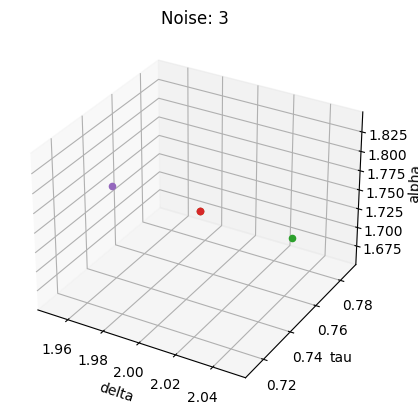

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

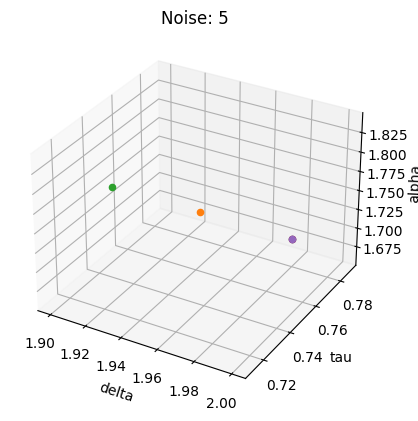

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

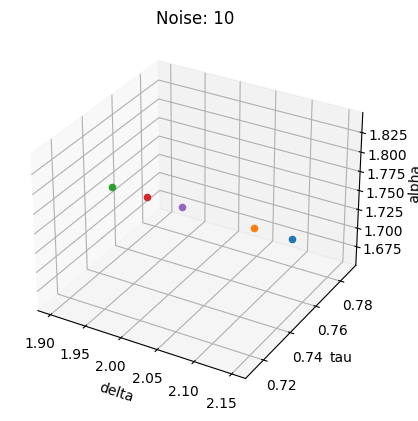

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta   tau alpha
0         1         0    1.754805  1.9500000000000008  0.75  1.75
1         1         3    1.750572  1.9500000000000008  0.75  1.75
2         1         6    1.592170  1.9500000000000008  0.75  1.75
3         1         8    1.778483  1.9500000000000008  0.75  1.75
4         1        10    1.741321  1.9500000000000008  0.75  1.75
...     ...       ...         ...                 ...   ...   ...
998      10        49   92.156941   2.200000000000001  0.75  1.75
999      10        52   93.910703   2.200000000000001  0.75  1.75
1000     10        12  102.923641   2.250000000000001  0.75  1.75
1001     10        65  105.003287   2.250000000000001  0.75  1.75
1002     10        92  101.446597   2.250000000000001  0.75  1.75

[1003 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                    
                       count  mean  std  min  25%  50%  75%  max
noise                                                           
1                      100.0  1.00  0.0  1.0  1.0  1.0  1.0  1.0
2                      100.0  1.00  0.0  1.0  1.0  1.0  1.0  1.0
3                      100.0  1.00  0.0  1.0  1.0  1.0  1.0  1.0
4                      100.0  1.00  0.0  1.0  1.0  1.0  1.0  1.0
5                      100.0  1.00  0.0  1.0  1.0  1.0  1.0  1.0
6                      100.0  1.00  0.0  1.0  1.0  1.0  1.0  1.0
7                      100.0  1.00  0.0  1.0  1.0  1.0  1.0  1.0
8                      100.0  1.02  0.2  1.0  1.0  1.0  1.0  3.0
9                      100.0  1.00  0.0  1.0  1.0  1.0  1.0  1.0
10                     100.0  1.01  0.1  1.0  1.0  1.0  1.0  2.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration        cost               delta   tau alpha
0         1         0    1.754805  1.9500000000000008  0.75  1.75
1         1         3    1.750572  1.9500000000000008  0.75  1.75
2         1         6    1.592170  1.9500000000000008  0.75  1.75
3         1         8    1.778483  1.9500000000000008  0.75  1.75
4         1        10    1.741321  1.9500000000000008  0.75  1.75
...     ...       ...         ...                 ...   ...   ...
998      10        49   92.156941   2.200000000000001  0.75  1.75
999      10        52   93.910703   2.200000000000001  0.75  1.75
1000     10        12  102.923641   2.250000000000001  0.75  1.75
1001     10        65  105.003287   2.250000000000001  0.75  1.75
1002     10        92  101.446597   2.250000000000001  0.75  1.75

[1002 rows x 6 columns]

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta   tau alpha
0         1         0    1.754805  1.9500000000000008  0.75  1.75
1         1         3    1.750572  1.9500000000000008  0.75  1.75
2         1         6    1.592170  1.9500000000000008  0.75  1.75
3         1         8    1.778483  1.9500000000000008  0.75  1.75
4         1        10    1.741321  1.9500000000000008  0.75  1.75
...     ...       ...         ...                 ...   ...   ...
998      10        49   92.156941   2.200000000000001  0.75  1.75
999      10        52   93.910703   2.200000000000001  0.75  1.75
1000     10        12  102.923641   2.250000000000001  0.75  1.75
1001     10        65  105.003287   2.250000000000001  0.75  1.75
1002     10        92  101.446597   2.250000000000001  0.75  1.75

[996 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                  
      count unique                 top freq count unique   top freq
noise                                                              
1       100      2   2.000000000000001   68   100      1  0.75  100
10       97     14  1.9500000000000008   17    97      1  0.75   97
2       100      4   2.000000000000001   53   100      1  0.75  100
3       100      4   2.000000000000001   42   100      1  0.75  100
4       100      6   2.000000000000001   36   100      1  0.75  100
5       100      7   2.000000000000001   28   100      1  0.75  100
6       100     10  1.9500000000000008   24   100      1  0.75  100
7       100     10  1.9500000000000008   20   100      1  0.75  100
8        99     10  1.9500000000000008   21    99      1  0.75   99
9       100     13   2.000000000000001   15   100      1  0.75  100

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

Empty DataFrame
Columns: [(delta, count), (delta, unique), (delta, top), (delta, freq), (tau, count), (tau, unique), (tau, top), (tau, freq)]
Index: []

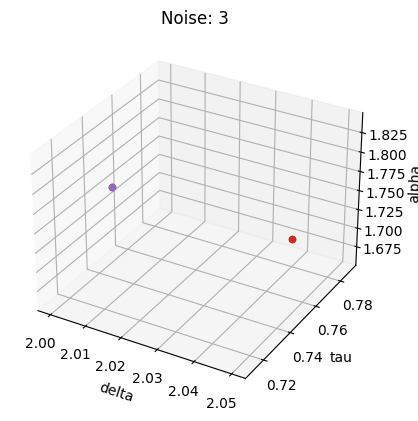

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

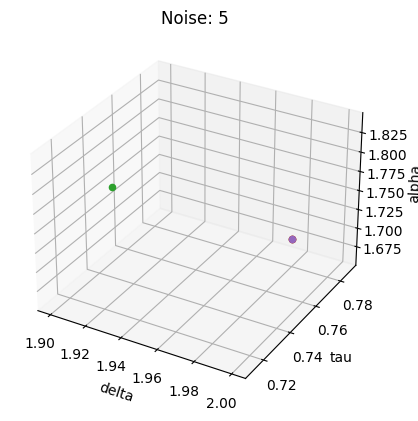

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

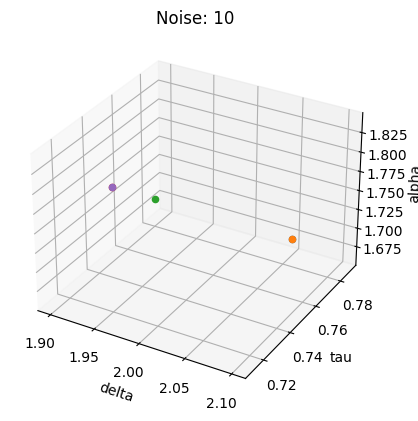

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()